# 인물사진 만들기
---

![이미지](https://4.bp.blogspot.com/-pQ1j2lyMvMw/WeUbl8BfPdI/AAAAAAAACDk/_nR4-zLdzIoaxOHhbb3AHPRSQRwhb8FfQCLcBGAs/s640/girl-with-the-orange-hat-s.jpg)

이번 프로젝트에서는 핸드폰카메라의 인물사진모드(portrait mode)를 구현해본다. 인물사진모드란 위 사진과 같이 인물만 명확히보이고 배경은 흐리게 보이게 만드는 기능이다. 인물사진모드 기능을 구현하기 위해 **Semantic Segmentation 모델인 DeepLab V3+** 를 사용할 것이다. 이미지 사진의 피사체(사람 또는 고양이)를 찾아 피사체는 그대로 나타내고 피사체을 제외한 배경은 아웃포커싱된것처럼 blur처리를하여 합성하는 것이다. 처리흐름은 아래와 같다.


### '인물사진 모드'인 사진 만들기 과정

- 배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
- 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
- 블러링(blurring) 기술로 배경을 흐리게 합니다.
- 피사체를 배경의 원래 위치에 합성합니다.

![dl](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp07/data/E-14-2.max-800x600_jKvxGUl.png?raw=true)


또한 DeepLab V3+ 모델을 이용해 만든 인물사진의 한계점을 짚어보고 이를 개선할수있는 방법도 함께 생각해보겠다.

---

# 1. 인물모드사진 구현

## 라이브러리

- urllib : 웹에서 데이터를 다운로드할 때 사용
- cv2 : OpenCV 라이브러리로 이미지를 처리
- pixellib : 시맨틱 세그멘테이션을 위한 기능 제공 
 - [Pixellib OFFICIAL DOCUMENTATION](https://pixellib.readthedocs.io/)
 - [Pixellib github](https://github.com/ayoolaolafenwa/PixelLib)
  


In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## DeepLab V3+ 모델 준비


- PixelLib를 이용하면 편하게 사용할 수 있다. PixelLib에서 제공해 주는 모델을 다운로드한다.

- semantic_segmentation : pixellib라이브러리의 시맨틱 세그멘테이션을 위한 클래스
- load_pascalvoc_model : 이 함수를 사용해 [**pascal voc 데이터셋**](http://host.robots.ox.ac.uk/pascal/VOC/index.html)에 대해 pretrained된 deeplabv3+ 모델을 불러온다. 
 - pre-trained 모델 : deeplabv3_xception_tf_dim_ordering_tf_kernels.h5 
 
## Pascal VOC data sets 
image detection을 위한 dataset으로 classification, object detection, segmentation 평가 알고리즘을 구축하거나 평가하는데 매우 유명한 데이터 셋.

Pascal VOC 데이터셋 구조는 아래와 같다
```
├── Annotations  : JPEGImages에 담겨있는 이미지 oject detection을 위한 정답 데이터. 
├── ImageSets : 특정 클래스가 어떤 이미지에 있는지 등에 대한 정보를 포함하는 폴더
├── JPEGImages : object dectection을 위한 입력 데이터. 이미지 파일들
├── SegmentationClass : Semantic segmentation을 학습하기위한 label 이미지들
└── SegmentationObject : Instance segmentation을 학습하기위한 label 이미지들
```

Pascal VOC data sets 은 20가지 오브젝트에 대한 데이터를 제공한다.

- Person: person
- Animal: bird, cat, cow, dog, horse, sheep
- Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
- Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

미리 라벨데이터를 정의해주겠다.

In [5]:
# PASCAL VOC 데이터의 라벨 종류는 아래와 같습니다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES) 

21

배경까지 포함하여 21가지 값(사람 -15, 고양이-8 등) 을 세그맨테이션에 대한 정보로 표시할수 있겠다.

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/project/exp07_HumanSegmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/project/exp07_HumanSegmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f402276ef40>)

In [4]:
#그다음 다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성합니다.
# 저장할 파일 이름을 결정합니다
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

## 1.1 인물모드 사진 - 고양이

(427, 640, 3)


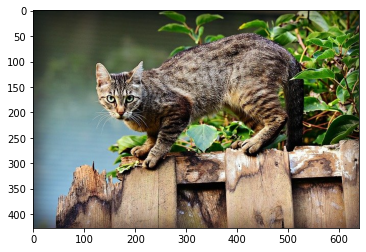

In [8]:
img_path = os.getenv('HOME')+'/aiffel/project/exp07_HumanSegmentation/images/cat5.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

이제 위 고양이 이미지를 DeepLab V3+ 모델에 입력처리해보겠다.  segmentAsPascalvoc라는 함수 이름처럼 PASCAL VOC 데이터로 학습된 정보를 이용하여 이미지에 있는 객체정보(20가지 객체에 대한 정보와 세그맨테이션값)가 리턴된다. 

In [13]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [14]:
segvalues

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
segvalues['masks'].shape

(427, 640)

segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 객체가 담겨 있는지 알수 있고, masks를 통해 해당 객체를 세그맨테이션할 수 있는 정보(True:해당객체, False:객체가 아닌부분)이 들어 있다.

In [12]:
for class_id in segvalues['class_ids']:
    print(class_id, LABEL_NAMES[class_id])

0 background
8 cat


class_ids 값으로 array([0, 8]) 이나왔다. 8에 대한 라벨인 고양이를 잘 세그맨테이션 했는지 리턴값으로 넘어온 output 으로 출력해보자

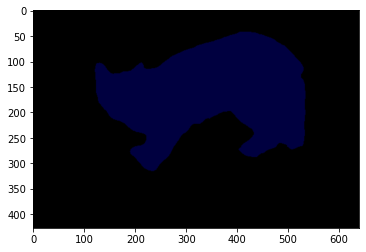

In [11]:
plt.imshow(output)
plt.show()

output으로 그린 이미지에 고양이부분이 파란색으로 세그멘테이션되어있다. 

각 객체마다 output에 어떤 색상은 아래와 같이 나타난다고 한다.

In [24]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 20가지 객체에 대해 세그맨테이션결과로 표시한다고 한다.
고양이와 사람에 대한 색상은 아래와 같다. 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다.
**colormap은 RGB 순서이므로 마스크적용시 BGR 순서로 바꿔주어야한다!**
- person : colormap[15] 
- cat : colormap[8] 

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있을 것이다.

In [26]:
#cat
label_index = 8
print('cat RGB : ', colormap[label_index]) #  RGB 순서
seg_color = (colormap[label_index][2],  colormap[label_index][1],  colormap[label_index][0]) 
print('cat BGR : ', seg_color) #  BGR 순서


cat RGB :  [64  0  0]
cat BGR :  (0, 0, 64)


### 피사체 세그맨테이션하기

(427, 640)


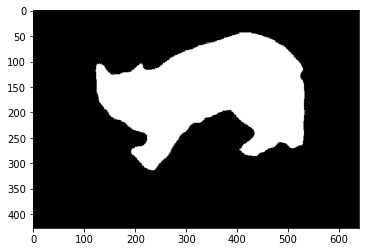

In [28]:
#이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

np.all 함수에 의해 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열로 seg_map 이미지(**img_mask**)가 생성되었다.
이 부분을 원래 이미지와 겹쳐 보자.

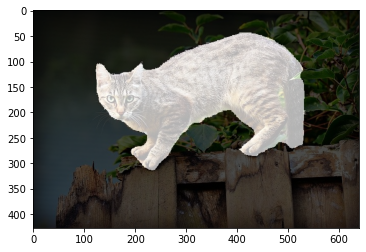

In [57]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_BONE)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.3과 0.7는 두 이미지를 섞는 비율입니다. (원본이미지를 약하게, 고양이 세그맨테이션부분이 더 드러나도록 설정해보았다.)
img_show = cv2.addWeighted(img_show, 0.3, color_mask, 0.7, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 흐리게 하기
인물사진모드에서 피사체 이외의 부분 흐리게 보이는 처리를 해보겠다. blur() 함수를 이용하여 원본 이미지 전체를 흐리게만든다.

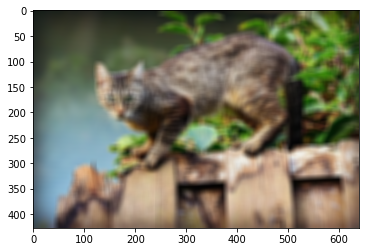

In [34]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 배경에서 피사체 지우기

위 흐린배경에서 피사체부분만 지워보겠다. 고양이 세그맨테이션 정보가 img_mask에 담겨있는데 이것을 반전(bitwise_not)하여 위 배경과and(bitwise_and)연산해주면된다. 


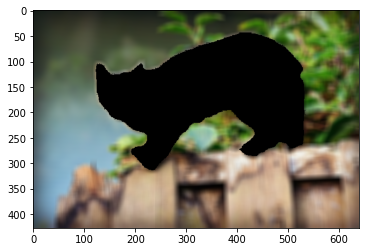

In [35]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) #피사체 마스크
img_bg_mask = cv2.bitwise_not(img_mask_color) #피사체 마스크마전하여 배경에 대한 마스크가됨
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경마스크와 위 blur이미지 합성
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 최종결과 - 인물모드사진
np.where 함수를 이용해 흐린 배경과 원본 이미지 합성해보겠다. 

- np.where(조건, 참일때 출력할 이미지, 거짓일때 출력할 이미지)
 - 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용한다.


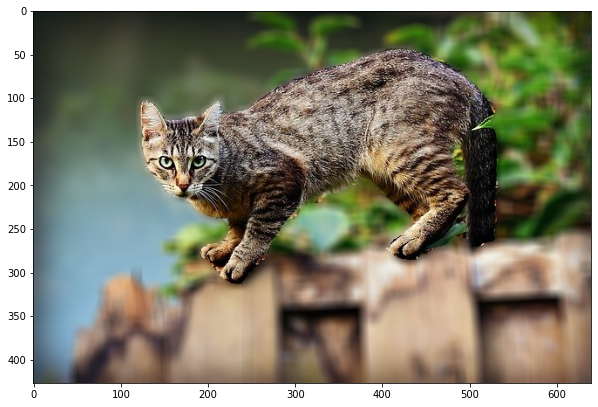

In [76]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

고양이에 대한 인물모드 사진을 완성하였다. 이제 인물에 대해 같은 과정을 진행해보겠다.

## 1.2 인물모드 사진 - 인물

(1032, 774, 3)


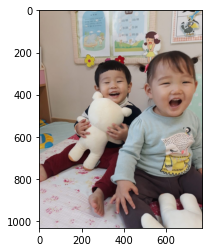

In [68]:
img_path2 = os.getenv('HOME')+'/aiffel/project/exp07_HumanSegmentation/images/img0.jpg'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

0 background
15 person


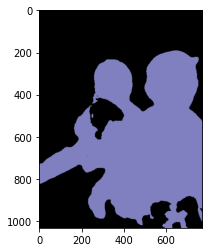

In [69]:
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

for class_id in segvalues2['class_ids']:
    print(class_id, LABEL_NAMES[class_id])
plt.imshow(output2)
plt.show()

In [60]:
# 15 person
label_index = 15
print('person RGB : ', colormap[label_index]) #  RGB 순서
seg_color = (colormap[label_index][2],  colormap[label_index][1],  colormap[label_index][0]) 
print('person BGR : ', seg_color) #  BGR 순서

person RGB :  [192 128 128]
person BGR :  (128, 128, 192)


(1032, 774)


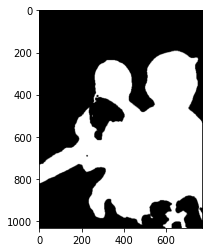

In [70]:
#이제 seg_color로만 이루어진 마스크를 만들어 봅시다.
seg_map2 = np.all(output2==seg_color, axis=-1)
print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

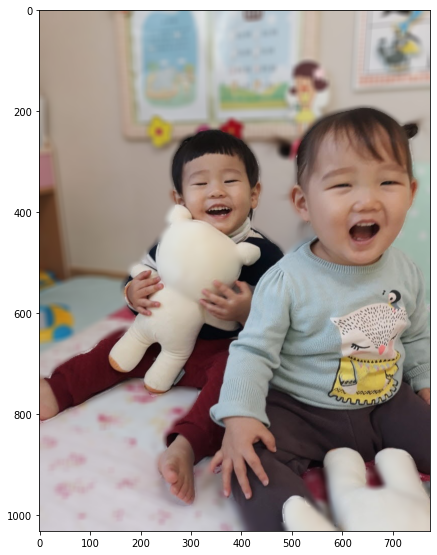

In [71]:
img_show2 = img_orig2.copy()
img_mask2 = seg_map2.astype(np.uint8) * 255

img_orig_blur2 = cv2.blur(img_orig2, (13,13))  
img_mask_color2 = cv2.cvtColor(img_mask2, cv2.COLOR_GRAY2BGR) #피사체 마스크
img_bg_mask2 = cv2.bitwise_not(img_mask_color2) #피사체 마스크마전하여 배경에 대한 마스크가됨
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2) # 배경마스크와 위 blur이미지 합성

# 원본과 흐린배경 합성
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.figure(figsize=(7,10))
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

## 1.3 배경전환 크로마키사진 - 고양이

우선 배경으로 합성할 이미지와 고양이 이미지의 사이즈가 다르므로 배경이미지를 고양이 이미지에 맞게 resize해준다.

In [45]:
print(img_orig.shape)
print(img_orig.shape[0], img_orig.shape[1])

(427, 640, 3)
427 640


배경 변경전 사이즈: (336, 640, 3)


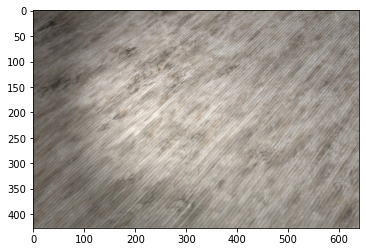

배경 변경후 사이즈: (427, 640, 3)


In [47]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path_bg = os.getenv('HOME')+'/aiffel/project/exp07_HumanSegmentation/images/bg5.jpg'  
img_orig_bg = cv2.imread(img_path_bg) 
print('배경 변경전 사이즈:', img_orig_bg.shape)
img_orig_bg = cv2.resize(img_orig_bg, (img_orig.shape[1],img_orig.shape[0] ))
plt.imshow(cv2.cvtColor(img_orig_bg, cv2.COLOR_BGR2RGB))
plt.show()
print('배경 변경후 사이즈:', img_orig_bg.shape)

배경에서 피사체 부분만 제외하는 처리를 해준다

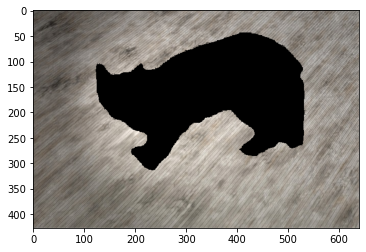

In [48]:
img_bg_withmask = cv2.bitwise_and(img_orig_bg, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_withmask, cv2.COLOR_BGR2RGB))
plt.show()

이제 위 배경과 고양이 사진 합성해주면된다. np.where함수를 사용하면 피사체의 마스크부분만 원본이미지를 나머지는 위에 마루배경이 나오게된다.

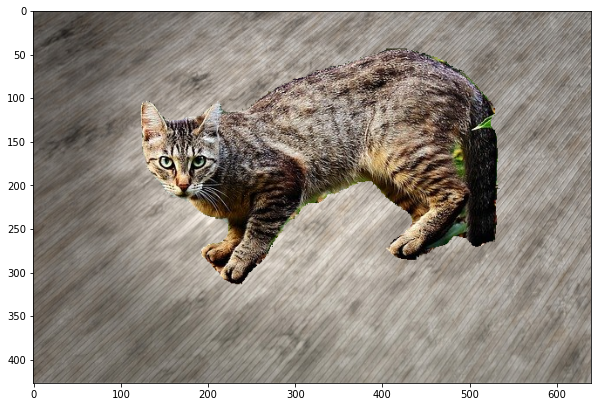

In [49]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_withmask)
plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 1.4 배경전환 크로마키사진 - 인물

In [72]:
print(img_orig2.shape)
print(img_orig2.shape[0], img_orig.shape[1])

(1032, 774, 3)
1032 640


배경 변경전 사이즈: (423, 640, 3)


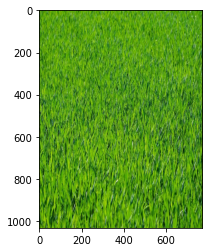

배경 변경후 사이즈: (1032, 774, 3)


In [73]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path_bg2 = os.getenv('HOME')+'/aiffel/project/exp07_HumanSegmentation/images/bg2.jpg'  
img_orig_bg2 = cv2.imread(img_path_bg2) 
print('배경 변경전 사이즈:', img_orig_bg2.shape)
img_orig_bg2 = cv2.resize(img_orig_bg2, (img_orig2.shape[1],img_orig2.shape[0] ))
plt.imshow(cv2.cvtColor(img_orig_bg2, cv2.COLOR_BGR2RGB))
plt.show()
print('배경 변경후 사이즈:', img_orig_bg2.shape)

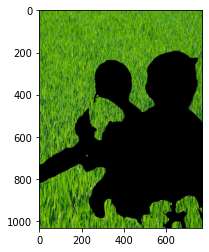

In [74]:
img_bg_withmask2 = cv2.bitwise_and(img_orig_bg2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_withmask2, cv2.COLOR_BGR2RGB))
plt.show()

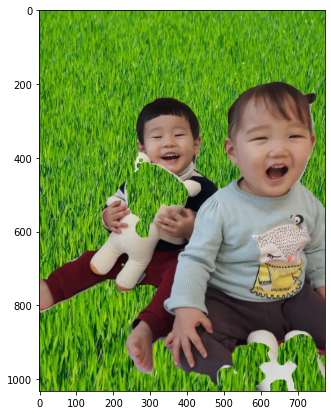

In [75]:
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_withmask2)
plt.figure(figsize=(10,7))
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))
plt.show()

---
# 2. 인물 모드사진의 문제점

인물사진모드로 고양이와 인물사진을 만들어보았다. 아웃포커싱효과가 적용된 사진에서는 잘나온것 처럼 보였는데 배경을 적용한 크로마키사진에는 확연하게 문제점이 보인다. 세그멘테이션이 피사체에 대해서 완전하게 적용되지 않은것이다.

![dl](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp07/data/problem1.png?raw=true)
![dl](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp07/data/problem2.png?raw=true)




대체적으로 피사체(고양이, 인물)에 대해 Segmentation이 잘되었지만 전체 픽셀에 대해 살펴보자면 완벽하지는 못하다. 핸드폰의 아웃포커싱 효과는  초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별하여 피사체를 배경과 구분해 내지만 DeepLab3 모델에 의한 semantic segmentation은 피사체와 배경에 대한 거리정보로 학습을 한것은 아니기때문에 그 구분에 한계가 있는듯하다. 

### 위 인물 모드사진의 문제점 정리해보자면 다음과 같다.
- 피사체에 포함될 부분이 포함되지않는 경우
- 피사체에 포함되지 않아야하는 부분이 포함되는 경우
- 피사체에 다른 객체가 포함되어있을때 그 객체를 정확히 구분하지 못하는 경우

결국 객체를 다른 객체와 구분하는 명확한 boundery를 설정하는것이 어려운 점 같다. 추가적으로 객체가 겹쳐지는 경우 그에 대한 구분은 더 어려워보인다. (안고있는 인형이 사람에서 제대로 분리되어있지 않다)

---
# 3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션?

## 3.1 DeepLab V3+ 모델에 대하여..
해결방법을 알아보기전에 DeepLab 모델의 Semantic Segmentation 방법에 대해 알아보자.

![이](https://images.velog.io/images/skhim520/post/beffeebf-a1a0-4200-9e3f-2b7ccf77af04/image.png)


### Encoder-Decoder with Atrous Convolution
고양이 사진을 입력했을 때 feature extraction 하는 과정을 Encoding 이라고 볼 수 있고 인코더를 통해 고양이 사진에 대한 FeatureMap이 나온다.
디코더는 압축된 FeatureMap을 다시 펼치며 픽셀별 예측, 즉 Semantic Segmentation을 진행한다. 

- Atrous Convolution
DeepLab은 Pooling에 의한 FeatureMap의 축소로 위치 정보가 손실되는 것을 막기위해 **Atrous Convolution** 기법을 사용한다.
![이](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-28_at_3.07.48_PM.png)


DeepLab은 pooling을 수행하지 않고도 Atrous Convolution 기법을 이용하여 receptive field를 크게 가져갈 수 있어서 spatial 정보의 손실이 적고 대부분의 weight가 0이기 때문에 연산의 효율도 좋다고 한다. 일반적인 CNN을 적용하면 출력은 입력에 비해 1/32로 줄어들었지만, Atrous 합성곱을 적용하면 1/8로 줄어들기때문에 특성 맵 크기가 기존 대비 4배 보존되는 것이다.

 -  Receptive field(수용영역) : 각 단계의 입력 이미지에 대해 하나의 필터가 커버할 수 있는 이미지 영역. 영상 전체 영역에 대해 서로 동일한 중요도를 부여하여 처리하는 대신, 특정 범위를 한정해서 처리하여 효과적으로 훈련을 수행하는 것이 수용 영역이라고 한다.

DeepLab V3+ 모델이 특성맵 크기를 많이 보존하여 Segmentation시 객체의 경계선을 잘 포착하도록 개발된 것을 확인할 수있다.
하지만 여전히 Feature map 의 값이 대응되는 pixel 개수가 많기 때문에 세세한 위치정보가 복원되기 어려우며 이 때문에 인물사진모드에서 객체에 대한 경계선이 명확히 나뉘지 않는 부분이 발생한것이 아닌가 한다.



## 3.1 EfficientNet-L2+NAS-FPN 모델 이용하기

DeepLab 모델의 Semantic Segmentation 한계점에 대한 해결방법으로 Semantic Segmentation 분야의 최신모델을 검색해보았다. SOTA(STATE OF THE ART)를 공개, 공유하는 인공지능 전문사이트 페이퍼위드코드(PAPERWITHCODE)에서 현재 PASCAL VOC 데이터셋에 대한 Semantic Segmentation이 좋은 모델은 **EfficientNet-L2+NAS-FPN** 이다. 

- [Semantic Segmentation on PASCAL VOC 2012 test Leaderboard](https://paperswithcode.com/sota/semantic-segmentation-on-pascal-voc-2012)
- 관련 논문 : [Rethinking Pre-training and Self-training](https://proceedings.neurips.cc//paper/2020/file/27e9661e033a73a6ad8cefcde965c54d-Paper.pdf)

meanIOU 가 90.5% 으로 89%인 DeepLabv3+ 보다 높다고 하니 Segmentation이 더 잘될것이라고 생각하여 해결안으로 생각해보았다.
앞으로 이 분야에 관심이 더생긴다면 실험을 통해 문제점이 있는 위 사진을 EfficientNet-L2+NAS-FPN 모델에 적용해서 실제로도 좋은 성능이 나오는지 확인해보면 좋겠다.

![이](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp07/data/supplement.png?raw=true)

## 3.2 HSV 색공간을 활용한 Segmentation

고양이 인물모드사진에서 배경은 확실히 카메라에서의 거리가 고양이 보다 멀다. 즉 이 깊이(depth)에 대한 정보를 함께 제공할수 있다면 좀더 정확한 세그멘테이션을 할수 있을것 같은데 이를 위해서는  RGB-D 카메라나 레이더가 필요하다고 한다. 다른 추가 기기나 데이터셋 없이 위 문제를 해결하는 방법으로 HSV로 이미지를 표현하여 객체를 인식하는것도 좋을 것 같다.
![이](https://miro.medium.com/max/1208/1*Uaf_UhURQZA3RL3VIBj2lg.png)

![이](https://miro.medium.com/max/1400/1*p3XMXQdj_kUVWPqqUF2hIg.png)

H채널은 색상 자체를 나타내고, S채널은 그 색의 진함을 나타내고, V채널은 밝기만을 나타내고 있다. 각채널중 H채널을 보니 원본이미지를 잘 추출할 수 있을 것같다. 물론 이미지에 따라 추출을 잘할수 있는 채널이 다르겠지만 이것들을 잘조합한다면 원하는 객체를 찾는데 큰도움이 될것이다.


---
# 4. 정리

인물사진모드를 구현하면서 Segmentation으로 편리하게 의미있는 객체를 추출하는 방법을 알게되었다. 객체를 추출하고나니 응용할분야도 많을 것임을 알수있는데 배경전환이나 추출한 객체간 합성등이 가능해져 카메라 앱등의 기본기술로 유용할 것 같았다. 하지만 배경이 있는 크로마키사진을 만들어보니 추출한 경계선이 아직 명확하지 않아 완벽한 작품을 만들기는 어려워보였다. 

그것을 위한 해결책을 찾아보는 3번째 과제는 당연히 필요한 과정이긴 했지만 아직 CNN, CV, 이미지에 대해 깊은 이해가 없는 상태에서 접근하기 매우 어려운 과제였다. 실제로 해결안이 효과적일지 알수 없어서 Deeplab모델 보다 성능이 좋은 최신모델을 찾아보았다. 해결안을 도출하기위해 DeepLab v3과 관련된 논문을 검색해보고 Semantic Segmentation 구현과 관련하여 Encoder, Decoder의 구조에 대해 전반적으로 살펴볼수있는 유익한 시간이였다.

---
# Reference
- [구글 인물사진 모드](https://ai.googleblog.com/2017/10/portrait-mode-on-pixel-2-and-pixel-2-xl.html)
- [Semantic segmentation of images with PixelLib using Pascalvoc model](https://pixellib.readthedocs.io/en/latest/Image_pascal.html?highlight=segmentaspascalvoc)
- [opencv-python tutorial](https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html)
- [PixelLib](https://pixellib.readthedocs.io/_/downloads/en/latest/pdf/)
- [Semantic Segmentation 첫걸음](https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb)
- 논문 : https://arxiv.org/pdf/2006.06882.pdf
- [FCN 2 DeepLab V3+](http://imlab.postech.ac.kr/dkim/class/csed514_2020s/fcn%20to%20deeplabv3.pdf)
- [HSV 색 공간을 활용해서 특정 색깔의 물체만 검출하기 ](https://bskyvision.com/46)
- [Image Segmentation HSV Segmentation](https://towardsdatascience.com/image-segmentation-part-1-6e0ddb5f7f8a)
